In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [3]:
import DarkVerse as dv


In [4]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

In [5]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}







In [7]:
### USING SELECTION CLASS
sub = dv.Selection(t, randoms, 0.4, 0.6, 10, 12.5, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended

# Fit HOD with custom bounds
hod_params, pcov = sub.fit_hod()

results = sub.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

HOD fit results: M_min = 10^0.00, M_1 = 10^12.64, alpha = 0.79


## HOD fit results: M_min = 10^12.50, M_1 = 10^13.72, alpha = 0.94




### WITHOUT BOOTSTRAP

<Figure size 1000x800 with 0 Axes>

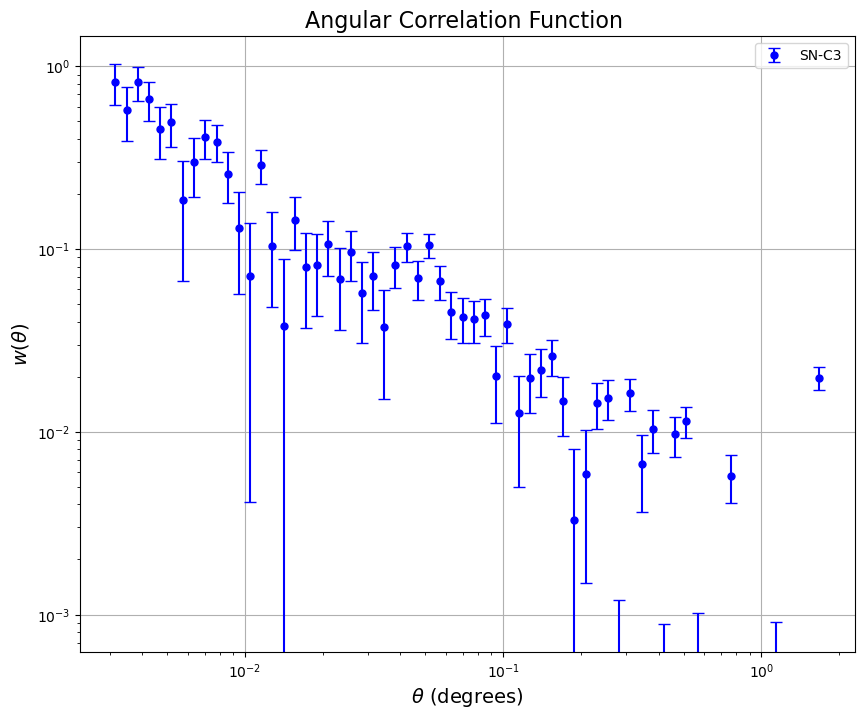

In [8]:
plt.figure(figsize=(10, 8))

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta'] #shot noise Shot noise or Poisson noise is a type of noise which can be modeled by a Poisson process.


w_err = np.sqrt(var_w_obs)



plt.figure(figsize=(10, 8))
plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', label= 'SN-C3', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

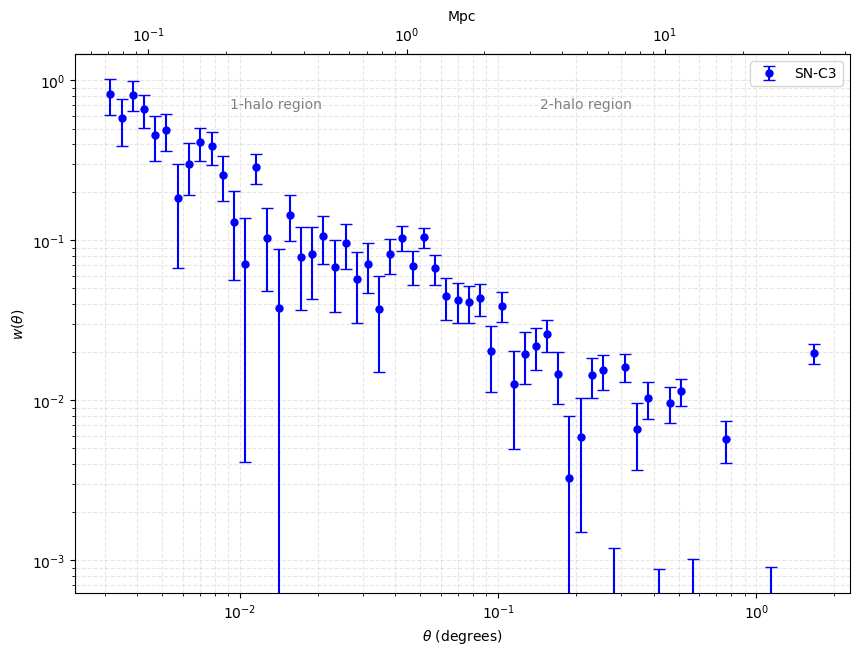

In [9]:
from astropy.cosmology import Planck15
plt.rcParams['text.usetex'] = False


z_mean = 0.5 


fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue',label= 'SN-C3', capsize=4, markersize=5)
#ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')

ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
#ax.set_title('Plot with Gaussian errors' )
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,10.])
#ax.set_xlim([8e-4,2.])
ax.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
ax.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
#ax.grid(True)
ax.grid(True, which="both", ls="--", alpha=0.3)



#y_at_1_degree = w_t(A_median, power_median, 1, mask_rr)
#ax.axhline(w_t(A_median, power_median, 1, mask_rr), color='r', linestyle='--', label='Model at 1 deg')



ax.legend()

### WITH BOOTSTRAP

<Figure size 1000x800 with 0 Axes>

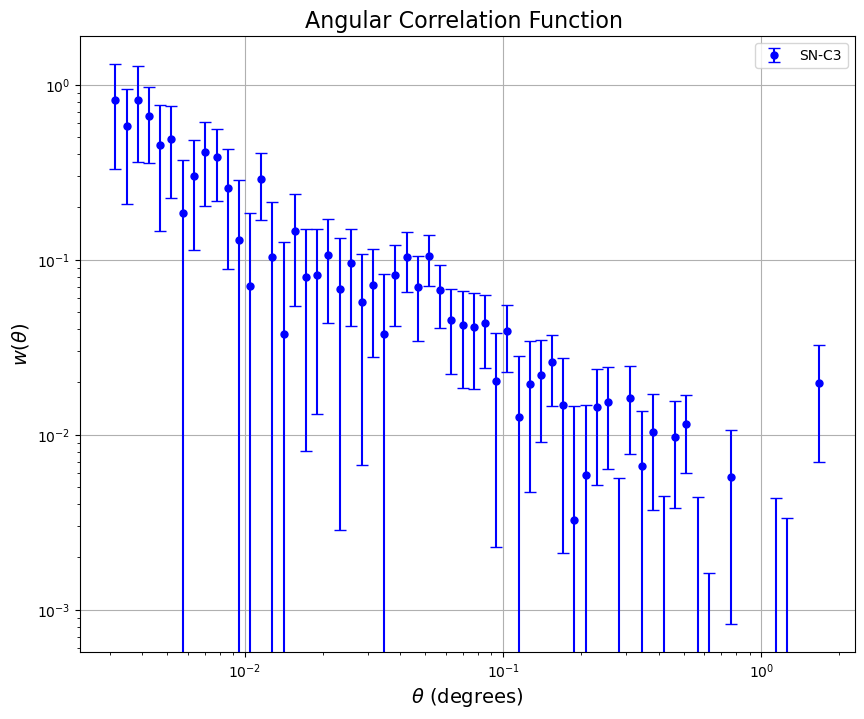

In [10]:
plt.figure(figsize=(10, 8))

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']

w_err = np.sqrt(var_w_obs)



plt.figure(figsize=(10, 8))
plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue',label= 'SN-C3', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

## Model prediction with best-fit parameters

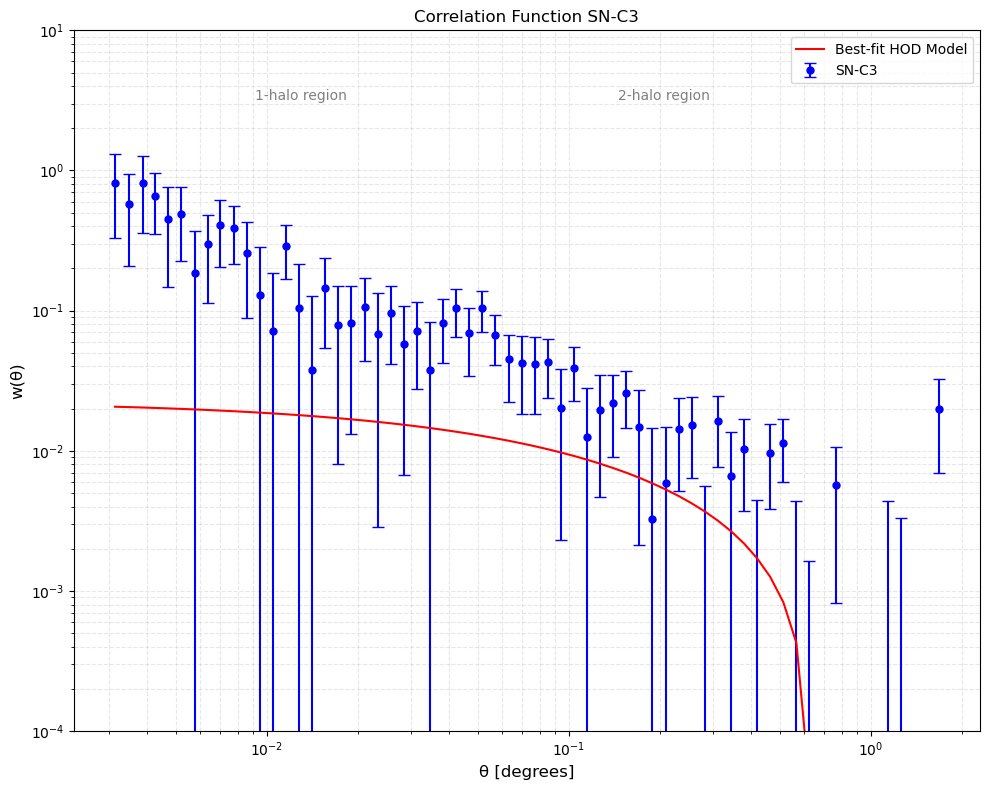

In [11]:

xi_m_values = results['xi_m']

# Model prediction with best-fit parameters
logM_min, logM_1, alpha = results['hod_params']
w_model = sub.hod_model(logM_min, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', label= 'SN-C3',capsize=4, markersize=5)
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')


plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'Correlation Function SN-C3')
plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()


In [12]:


one_halo = sub.gg.corr_1h_auto_matter *0.002
two_halo =sub.gg.corr_2h_auto_matter*0.007
w_m= sub.gg.angular_corr_matter
w_g = sub.gg.angular_corr_gal


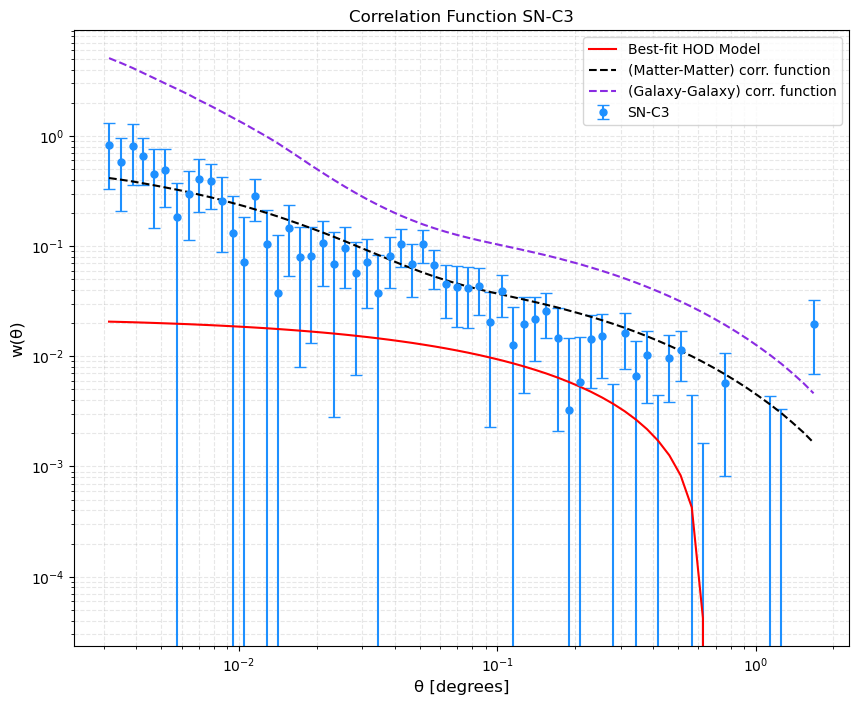

In [14]:
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']


# Model prediction with best-fit parameters
logM_min, logM_1, alpha = results['hod_params']
w_model = sub.hod_model(logM_min, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='dodgerblue', label= 'SN-C3',capsize=4, markersize=5)
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
plt.plot(theta, xi_m_values, label=r'(Matter-Matter) corr. function', linestyle='dashed', color='black')
plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4, 10.])
plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title('Correlation Function SN-C3')

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.show()


from astropy.cosmology import Planck15
plt.rcParams['text.usetex'] = False


z_mean = 0.5 


fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', capsize=4, markersize=5)
ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')

ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.grid(True)


#y_at_1_degree = w_t(A_median, power_median, 1, mask_rr)
#ax.axhline(w_t(A_median, power_median, 1, mask_rr), color='r', linestyle='--', label='Model at 1 deg')



ax.legend()

## ^what is going on in the middle ???

In [15]:
bias_eff = sub.gg.bias_effective_tracer #The tracer occupation-weighted halo bias factor (Tinker 2005).
print(f"Effective galaxy bias: {bias_eff:.3f}")


Effective galaxy bias: 0.593


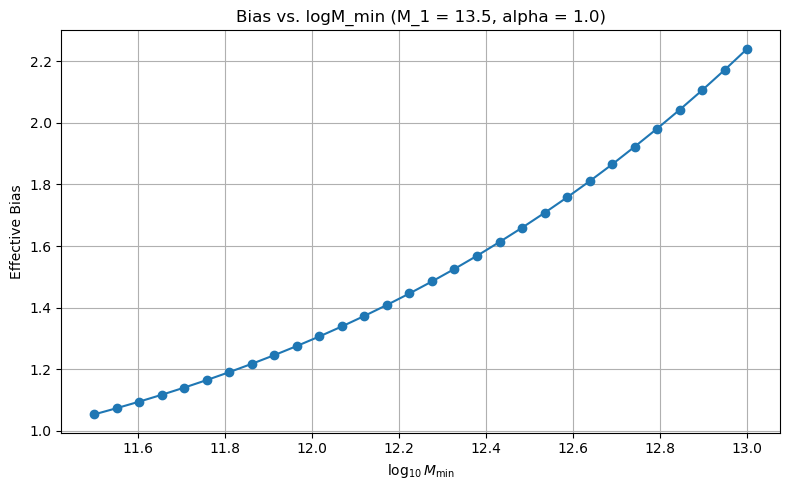

In [16]:
logM_1_fixed = 13.5
alpha_fixed = 1.0

logM_min_vals = np.linspace(11.5, 13.0, 30)
bias_vals = []

for logM_min in logM_min_vals:
    sub.hod_model(logM_min, logM_1_fixed, alpha_fixed)
    bias = sub.gg.bias_effective_tracer
    bias_vals.append(bias)

plt.figure(figsize=(8, 5))
plt.plot(logM_min_vals, bias_vals, marker='o')
plt.xlabel(r"$\log_{10} M_{\mathrm{min}}$")
plt.ylabel("Effective Bias")
plt.title("Bias vs. logM_min (M_1 = 13.5, alpha = 1.0)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
mask = (theta >= 0.1) & (theta <= 0.4)

bias_estimator = dv.BiasEstimator(
    xi_g=results['xi_g'],
    xi_m=results['xi_m'],
    w_theta_list= w_obs,
    w_theta_error_list=w_err,
    sum_rr_list=[results['rr_counts']],
    mask=mask
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [1.2753934822118258]
Bias errors: [0.04438119774213996]


# Now trying all my fields and different redshift bins using Selection class that finds the best fit for my 3 HOD parameters

In [39]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

SM_min, SM_max = 10, 12.5  # High SM
z_ranges = [(0.0, 0.2),(0.2, 0.4), (0.4, 0.6),(0.6, 0.8), (0.8,1.0)]
colors = ["blue", "green", "red", "purple", "orange"]  # Different color for each redshift bin


# Initialize storage for all results
all_results = {z_range: {} for z_range in z_ranges}

# Process each redshift range
for z_min, z_max in z_ranges:
    print(f"\n\n🔹 Processing redshift range {z_min}-{z_max}")
    
    # Initialize bias estimator for this redshift range (using first field as reference)
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    # Process each field for this redshift range
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        # Load data
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id')
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        # Compute subsample
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        hod_params, pcov = subsample.fit_hod()

        results = subsample.get_results()
        
        # Get effective bias from gg
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")

        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        
        # Add to estimator
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),  # Using bootstrap errors
            sum_rr=np.array(results['rr_counts'])
        )
    
    # 1. Fit individual fields
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    # 2. Get combined bias estimate
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    # 3. Store results
    all_results[(z_min, z_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict  # per-field biases
    }

    




🔹 Processing redshift range 0.0-0.2
The following patch numbers have no objects: {1, 2, 33, 34, 5, 37, 9, 44, 13, 15, 18, 20, 22, 27, 31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {33, 2, 35, 10, 11, 17, 49, 19, 20, 24, 26, 27, 30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {2, 37, 7, 8, 40, 42, 12, 45, 47, 48, 20, 22, 24, 26, 30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {2, 4, 37, 6, 8, 42, 11, 44, 47, 16, 23, 25, 26, 29, 30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 2, 3, 37, 7, 43, 45, 47, 49, 20, 22, 30, 31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 3, 35, 6, 8, 41, 11, 43, 15, 47, 17, 49, 22, 25, 31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 3, 36, 5, 38,

# High SM SM_min, SM_max = 10, 12.5  
# z_ranges = [(0.0, 0.2),(0.2, 0.4), (0.4, 0.6),(0.6, 0.8), (0.8,1.0)]

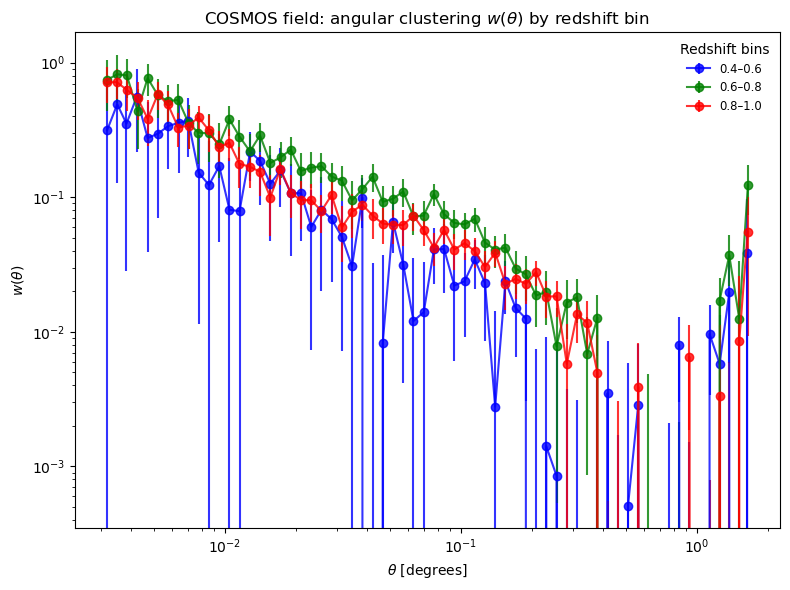

In [147]:

z_ranges = [(0.4, 0.6),(0.6, 0.8), (0.8,1.0)]
plt.figure(figsize=(8,6))

for (z_min, z_max), color in zip(z_ranges, colors):
    # ── load the COSMOS catalog + mask + randoms ──
    paths = fields['COSMOS']
    cat = Table.read(os.path.join(thesis_path, paths["catalog"]))
    msk = Table.read(os.path.join(thesis_path, paths["masked"]))
    cat = join(cat, msk, keys='id')
    cat.rename_columns(['ra_1','dec_1'], ['ra','dec'])
    rnd = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # ── select and get results ──
    subs = dv.Selection(
        catalog=cat,
        randoms=rnd,
        z_min=z_min, z_max=z_max,
        SM_min=SM_min, SM_max=SM_max,
        config=config
    )
    res = subs.get_results()
    theta    = np.array(res['theta'])
    wtheta   = np.array(res['w_theta'])
    wtheta_e = np.sqrt(np.array(res['var_w_theta_bootstrap']))

    # ── plot with error bars ──
    plt.errorbar(theta, wtheta, yerr=wtheta_e, fmt='-o',
                 color=color, label=f'{z_min:.1f}–{z_max:.1f}', alpha=0.8)

# ── formatting ──
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [degrees]')
plt.ylabel(r'$w(\theta)$')
plt.title('COSMOS field: angular clustering $w(\\theta)$ by redshift bin')
plt.legend(title='Redshift bins', frameon=False, fontsize='small')
plt.tight_layout()
plt.show()


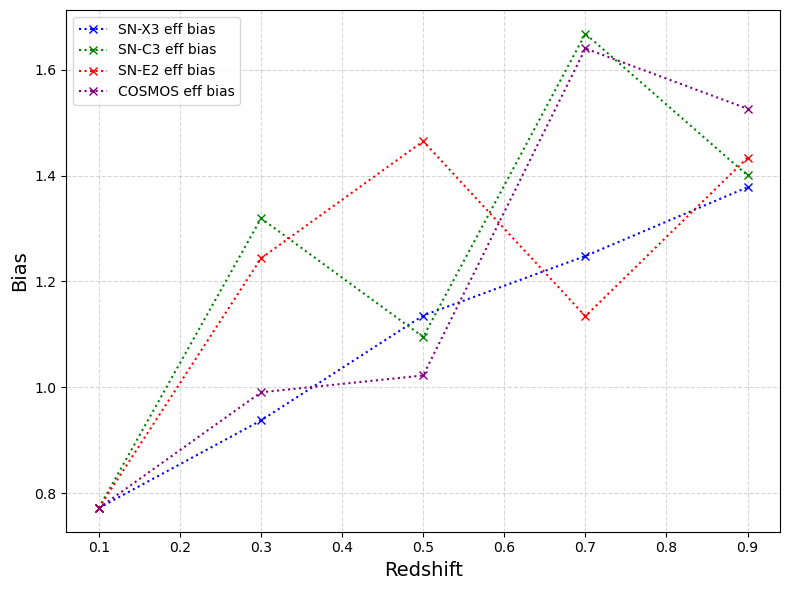

In [47]:

plt.figure(figsize=(8, 6))

colors = ["blue", "green", "red", "purple", "orange"]  # Color per field

# Set up redshift bin centers
z_centers = [(zmin + zmax) / 2 for (zmin, zmax) in z_ranges]

field_names = list(fields.keys())
field_biases = {field: [] for field in field_names}
field_errors = {field: [] for field in field_names}
global_biases = []
global_errors = []
computed_global_biases = []
computed_global_errors = []

biases_eff_by_field = {field: [] for field in field_names}

for z_bin in z_ranges:
    results = all_results[z_bin]['individual']
    result_dict = {name: (b, be) for name, b, be, _ in results}

    # Collect for global bias computation
    weighted_sum = 0.0
    weight_sum = 0.0

    for field in field_names:
        b, be = result_dict.get(field, (None, None))
        if b is not None and be is not None and be > 0:
            field_biases[field].append(b)
            field_errors[field].append(be)
            weight = 1.0 / (be ** 2)
            weighted_sum += b * weight
            weight_sum += weight
        else:
            field_biases[field].append(None)
            field_errors[field].append(None)

    if weight_sum > 0:
        b_global = weighted_sum / weight_sum
        be_global = np.sqrt(1.0 / weight_sum)
    else:
        b_global = None
        be_global = None

    computed_global_biases.append(b_global)
    computed_global_errors.append(be_global)

    # Get effective biases
    bias_eff_dict = all_results[z_bin]['bias_eff']
    for field in field_names:
        eff_bias = bias_eff_dict.get(field, None)
        biases_eff_by_field[field].append(eff_bias)



# Plot effective biases
for i, field in enumerate(field_names):
    plt.plot(z_centers,
             biases_eff_by_field[field],
             label=f'{field} eff bias',
             color=colors[i],
             marker='x',
             linestyle=':')



plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Bias", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("Bias_eff_vs_z_for_High_SM.png")
plt.show()


# Compute the global bias by inverse weighting the fields'biases

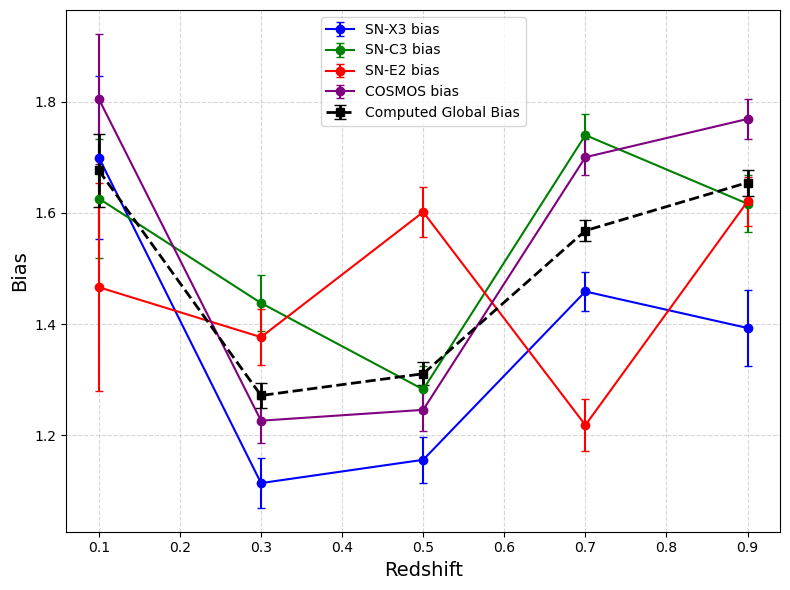

In [46]:
plt.figure(figsize=(8, 6))

colors = ["blue", "green", "red", "purple", "orange"]  # Color per field

# Set up redshift bin centers
z_centers = [(zmin + zmax) / 2 for (zmin, zmax) in z_ranges]

field_names = list(fields.keys())
field_biases = {field: [] for field in field_names}
field_errors = {field: [] for field in field_names}
global_biases = []
global_errors = []
computed_global_biases = []
computed_global_errors = []

biases_eff_by_field = {field: [] for field in field_names}

for z_bin in z_ranges:
    results = all_results[z_bin]['individual']
    result_dict = {name: (b, be) for name, b, be, _ in results}

    # Collect for global bias computation
    weighted_sum = 0.0
    weight_sum = 0.0

    for field in field_names:
        b, be = result_dict.get(field, (None, None))
        if b is not None and be is not None and be > 0:
            field_biases[field].append(b)
            field_errors[field].append(be)
            weight = 1.0 / (be ** 2)
            weighted_sum += b * weight
            weight_sum += weight
        else:
            field_biases[field].append(None)
            field_errors[field].append(None)

    if weight_sum > 0:
        b_global = weighted_sum / weight_sum
        be_global = np.sqrt(1.0 / weight_sum)
    else:
        b_global = None
        be_global = None

    computed_global_biases.append(b_global)
    computed_global_errors.append(be_global)

    # Get effective biases
    bias_eff_dict = all_results[z_bin]['bias_eff']
    for field in field_names:
        eff_bias = bias_eff_dict.get(field, None)
        biases_eff_by_field[field].append(eff_bias)

# Plot individual field biases
for i, field in enumerate(field_names):
    plt.errorbar(z_centers,
                 field_biases[field],
                 yerr=field_errors[field],
                 label=f'{field} bias',
                 color=colors[i],
                 marker='o',
                 capsize=3,
                 linestyle='-')


# Plot computed global bias
plt.errorbar(z_centers,
             computed_global_biases,
             yerr=computed_global_errors,
             label='Computed Global Bias',
             color='black',
             marker='s',
             linestyle='--',
             capsize=4,
             linewidth=2)

plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Bias", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig( "Bias_g_vs_z_for_High_SM.png")
plt.show()

# Compute delta_g and delta_dm


In [51]:
# Compute delta_g and delta_dm
field_delta_g = {field: [] for field in field_names}
field_delta_dm = {field: [] for field in field_names}

for i, z_bin in enumerate(z_ranges):
    b_global = computed_global_biases[i]
    if b_global is None or b_global == 0:
        for field in field_names:
            field_delta_g[field].append(None)
            field_delta_dm[field].append(None)
        continue

    for field in field_names:
        b = field_biases[field][i]
        if b is None or b <= 0:
            field_delta_g[field].append(None)
            field_delta_dm[field].append(None)
            continue

        f = b / b_global
        delta_g = (21.0 / 68.0) * np.log(f) # np.log is ln, whereas np.log10 is standard base 10 log.
        delta_dm = delta_g / b_global

        field_delta_g[field].append(delta_g)
        field_delta_dm[field].append(delta_dm)


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1362999/502576764.py:5: SyntaxWarning: invalid escape sequence '\d'
  label=f'{field} $\delta_g$',
/tmp/ipykernel_1362999/502576764.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.title("Galaxy Density Fluctuation ($\delta_g$) vs Redshift", fontsize=15)


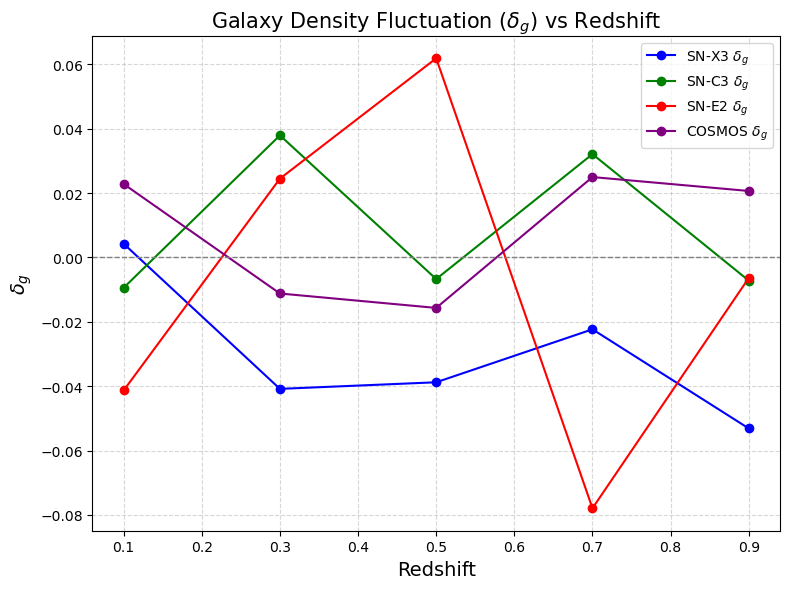

In [52]:
plt.figure(figsize=(8, 6))
for i, field in enumerate(field_names):
    plt.plot(z_centers,
             field_delta_g[field],
             label=f'{field} $\delta_g$',
             color=colors[i],
             marker='o',
             linestyle='-')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\delta_g$", fontsize=14)
plt.title("Galaxy Density Fluctuation ($\delta_g$) vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("delta_g_vs_z.png")
plt.show()


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1362999/1008739455.py:5: SyntaxWarning: invalid escape sequence '\d'
  label=f'{field} $\delta_{{dm}}$',
/tmp/ipykernel_1362999/1008739455.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.title("Dark Matter Density Fluctuation ($\delta_{dm}$) vs Redshift", fontsize=15)


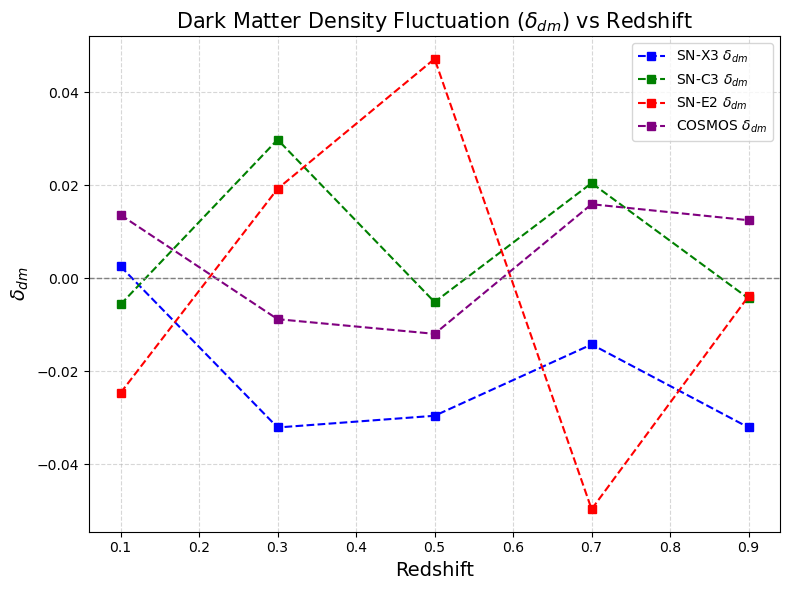

In [53]:
plt.figure(figsize=(8, 6))
for i, field in enumerate(field_names):
    plt.plot(z_centers,
             field_delta_dm[field],
             label=f'{field} $\delta_{{dm}}$',
             color=colors[i],
             marker='s',
             linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\delta_{dm}$", fontsize=14)
plt.title("Dark Matter Density Fluctuation ($\delta_{dm}$) vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("delta_dm_vs_z.png")
plt.show()


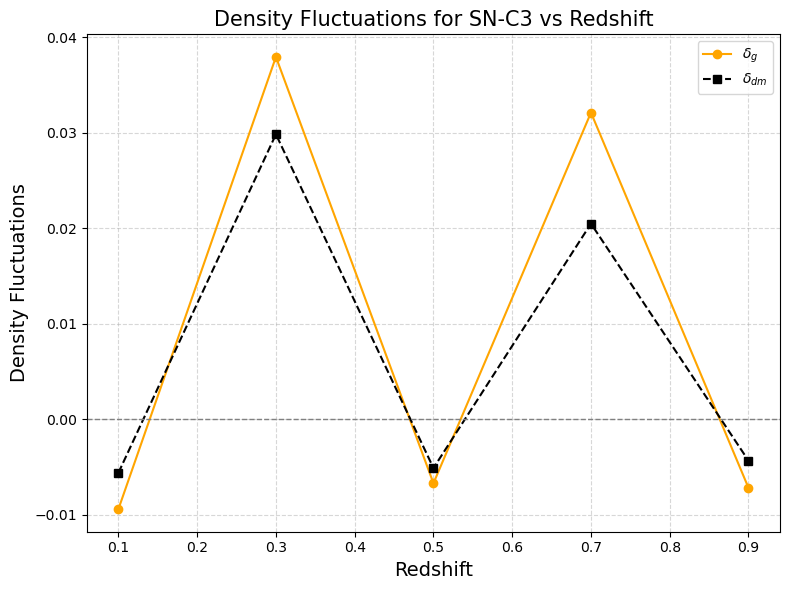

In [65]:
field = "SN-C3"



plt.figure(figsize=(8, 6))

# Plot delta_g
plt.plot(z_centers,
         field_delta_g[field],
         label=r'$\delta_g$',
         color='orange',
         marker='o',
         linestyle='-')

# Plot delta_dm
plt.plot(z_centers,
         field_delta_dm[field],
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Density Fluctuations", fontsize=14)
plt.title(f"Density Fluctuations for {field} vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_g_and_dm_vs_z_{field}.png")
plt.show()


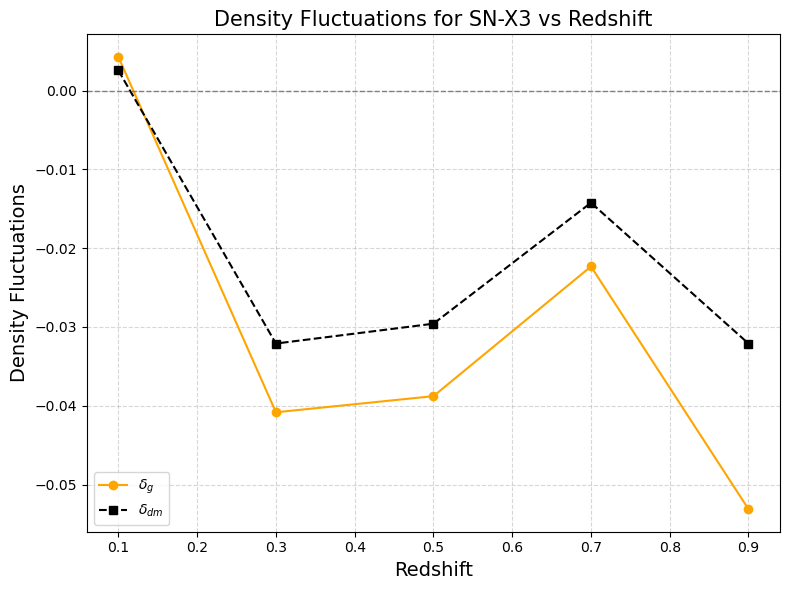

In [66]:
field = "SN-X3"


plt.figure(figsize=(8, 6))

# Plot delta_g
plt.plot(z_centers,
         field_delta_g[field],
         label=r'$\delta_g$',
         color='orange',
         marker='o',
         linestyle='-')

# Plot delta_dm
plt.plot(z_centers,
         field_delta_dm[field],
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Density Fluctuations", fontsize=14)
plt.title(f"Density Fluctuations for {field} vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_g_and_dm_vs_z_{field}.png")
plt.show()

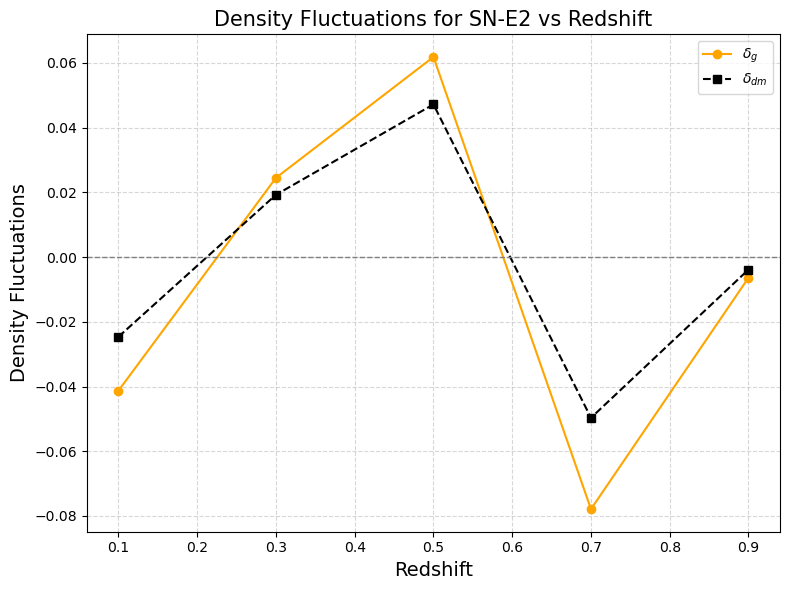

In [67]:
field = "SN-E2"



plt.figure(figsize=(8, 6))

# Plot delta_g
plt.plot(z_centers,
         field_delta_g[field],
         label=r'$\delta_g$',
         color='orange',
         marker='o',
         linestyle='-')

# Plot delta_dm
plt.plot(z_centers,
         field_delta_dm[field],
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Density Fluctuations", fontsize=14)
plt.title(f"Density Fluctuations for {field} vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_g_and_dm_vs_z_{field}.png")
plt.show()

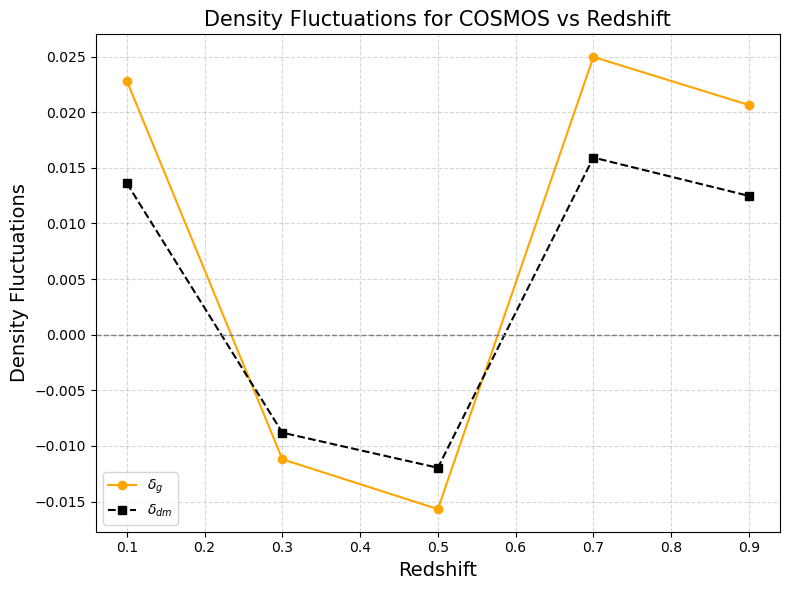

In [68]:
field = "COSMOS"



plt.figure(figsize=(8, 6))

# Plot delta_g
plt.plot(z_centers,
         field_delta_g[field],
         label=r'$\delta_g$',
         color='orange',
         marker='o',
         linestyle='-')

# Plot delta_dm
plt.plot(z_centers,
         field_delta_dm[field],
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Density Fluctuations", fontsize=14)
plt.title(f"Density Fluctuations for {field} vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_g_and_dm_vs_z_{field}.png")
plt.show()

# !!!!!! Plot only from z=0.2!!!

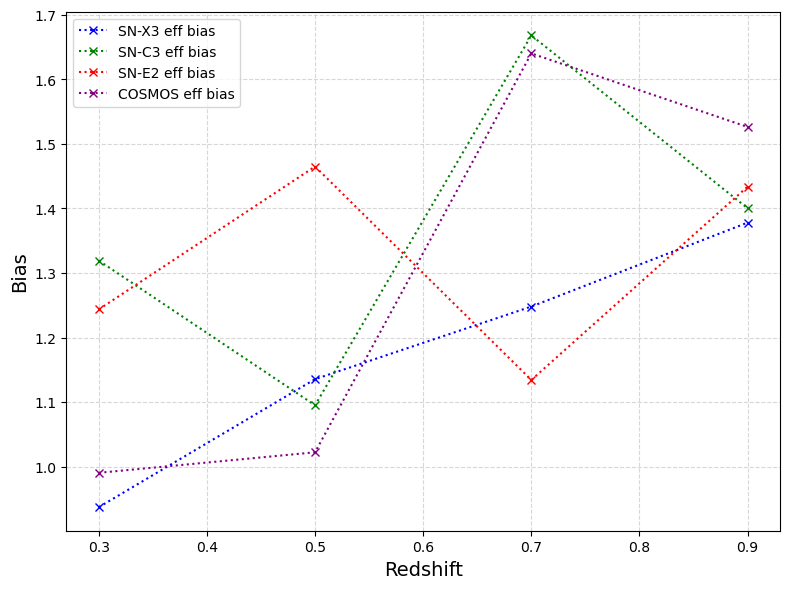

In [88]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

colors = ["blue", "green", "red", "purple", "orange"]  # Color per field

# Set up redshift bin centers
z_centers = [(zmin + zmax) / 2 for (zmin, zmax) in z_ranges]

field_names = list(fields.keys())
field_biases = {field: [] for field in field_names}
field_errors = {field: [] for field in field_names}
computed_global_biases = []
computed_global_errors = []
biases_eff_by_field = {field: [] for field in field_names}

for z_bin in z_ranges:
    results = all_results[z_bin]['individual']
    result_dict = {name: (b, be) for name, b, be, _ in results}

    weighted_sum = 0.0
    weight_sum = 0.0

    for field in field_names:
        b, be = result_dict.get(field, (None, None))
        if b is not None and be is not None and be > 0:
            field_biases[field].append(b)
            field_errors[field].append(be)
            weight = 1.0 / (be ** 2)
            weighted_sum += b * weight
            weight_sum += weight
        else:
            field_biases[field].append(None)
            field_errors[field].append(None)

    if weight_sum > 0:
        b_global = weighted_sum / weight_sum
        be_global = np.sqrt(1.0 / weight_sum)
    else:
        b_global = None
        be_global = None

    computed_global_biases.append(b_global)
    computed_global_errors.append(be_global)

    bias_eff_dict = all_results[z_bin]['bias_eff']
    for field in field_names:
        eff_bias = bias_eff_dict.get(field, None)
        biases_eff_by_field[field].append(eff_bias)

# Filter to keep only redshifts >= 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]

z_centers_filtered = [z_centers[i] for i in indices]
biases_eff_by_field_filtered = {
    field: [biases_eff_by_field[field][i] for i in indices] for field in field_names
}

# Plot effective biases from z=0.2 only
for i, field in enumerate(field_names):
    plt.plot(z_centers_filtered,
             biases_eff_by_field_filtered[field],
             label=f'{field} eff bias',
             color=colors[i],
             marker='x',
             linestyle=':')

plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Bias", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("Bias_eff_vs_z_for_High_SM.png")
plt.show()


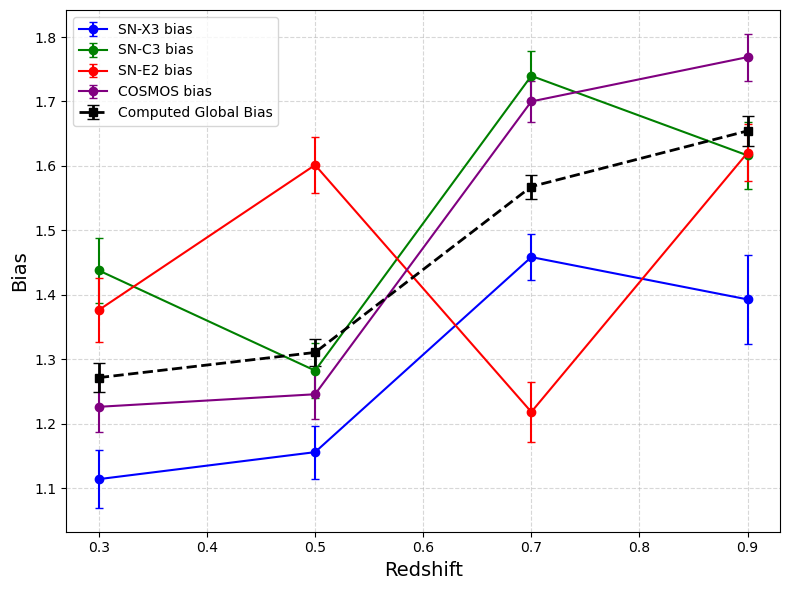

In [89]:


plt.figure(figsize=(8, 6))

colors = ["blue", "green", "red", "purple", "orange"]  # Color per field

# Set up redshift bin centers
z_centers = [(zmin + zmax) / 2 for (zmin, zmax) in z_ranges]

field_names = list(fields.keys())
field_biases = {field: [] for field in field_names}
field_errors = {field: [] for field in field_names}
computed_global_biases = []
computed_global_errors = []

biases_eff_by_field = {field: [] for field in field_names}

for z_bin in z_ranges:
    results = all_results[z_bin]['individual']
    result_dict = {name: (b, be) for name, b, be, _ in results}

    weighted_sum = 0.0
    weight_sum = 0.0

    for field in field_names:
        b, be = result_dict.get(field, (None, None))
        if b is not None and be is not None and be > 0:
            field_biases[field].append(b)
            field_errors[field].append(be)
            weight = 1.0 / (be ** 2)
            weighted_sum += b * weight
            weight_sum += weight
        else:
            field_biases[field].append(None)
            field_errors[field].append(None)

    if weight_sum > 0:
        b_global = weighted_sum / weight_sum
        be_global = np.sqrt(1.0 / weight_sum)
    else:
        b_global = None
        be_global = None

    computed_global_biases.append(b_global)
    computed_global_errors.append(be_global)

    bias_eff_dict = all_results[z_bin]['bias_eff']
    for field in field_names:
        eff_bias = bias_eff_dict.get(field, None)
        biases_eff_by_field[field].append(eff_bias)

# Filter to keep only redshifts >= 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]

z_centers_filtered = [z_centers[i] for i in indices]
field_biases_filtered = {field: [field_biases[field][i] for i in indices] for field in field_names}
field_errors_filtered = {field: [field_errors[field][i] for i in indices] for field in field_names}
computed_global_biases_filtered = [computed_global_biases[i] for i in indices]
computed_global_errors_filtered = [computed_global_errors[i] for i in indices]

# Plot individual field biases
for i, field in enumerate(field_names):
    plt.errorbar(z_centers_filtered,
                 field_biases_filtered[field],
                 yerr=field_errors_filtered[field],
                 label=f'{field} bias',
                 color=colors[i],
                 marker='o',
                 capsize=3,
                 linestyle='-')

# Plot computed global bias
plt.errorbar(z_centers_filtered,
             computed_global_biases_filtered,
             yerr=computed_global_errors_filtered,
             label='Computed Global Bias',
             color='black',
             marker='s',
             linestyle='--',
             capsize=4,
             linewidth=2)

plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Bias", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("Bias_g_vs_z_for_High_SM.png")
plt.show()


# !!!Compute delta_g and delta_dm


In [93]:
# Compute delta_g and delta_dm
field_delta_g = {field: [] for field in field_names}
field_delta_dm = {field: [] for field in field_names}

for i, z_bin in enumerate(z_ranges):
    b_global = computed_global_biases[i]
    if b_global is None or b_global == 0:
        for field in field_names:
            field_delta_g[field].append(None)
            field_delta_dm[field].append(None)
        continue

    for field in field_names:
        b = field_biases[field][i]
        if b is None or b <= 0:
            field_delta_g[field].append(None)
            field_delta_dm[field].append(None)
            continue

        f = (b / b_global)**2  # Square the ratio!
        delta_g = (21.0 / 68.0) * np.log(f)  # Natural log (ln)
        delta_dm = delta_g / b_global

        field_delta_g[field].append(delta_g)
        field_delta_dm[field].append(delta_dm)


<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1362999/3503822920.py:13: SyntaxWarning: invalid escape sequence '\d'
  label=f'{field} $\delta_g$',
/tmp/ipykernel_1362999/3503822920.py:21: SyntaxWarning: invalid escape sequence '\d'
  plt.title("Galaxy Density Fluctuation ($\delta_g$) vs Redshift", fontsize=15)


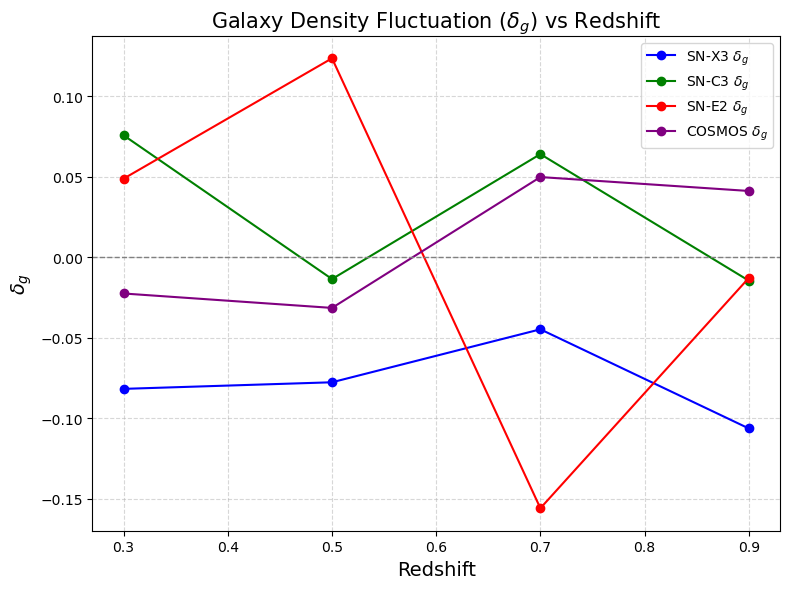

In [94]:
plt.figure(figsize=(8, 6))

# Filter to keep only redshifts >= 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]

z_centers_filtered = [z_centers[i] for i in indices]
field_delta_g_filtered = {field: [field_delta_g[field][i] for i in indices] for field in field_names}

for i, field in enumerate(field_names):
    plt.plot(z_centers_filtered,
             field_delta_g_filtered[field],
             label=f'{field} $\delta_g$',
             color=colors[i],
             marker='o',
             linestyle='-')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\delta_g$", fontsize=14)
plt.title("Galaxy Density Fluctuation ($\delta_g$) vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("delta_g_vs_z.png")
plt.show()


<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1362999/3498746706.py:13: SyntaxWarning: invalid escape sequence '\d'
  label=f'{field} $\delta_{{dm}}$',
/tmp/ipykernel_1362999/3498746706.py:21: SyntaxWarning: invalid escape sequence '\d'
  plt.title("Dark Matter Density Fluctuation ($\delta_{dm}$) vs Redshift", fontsize=15)


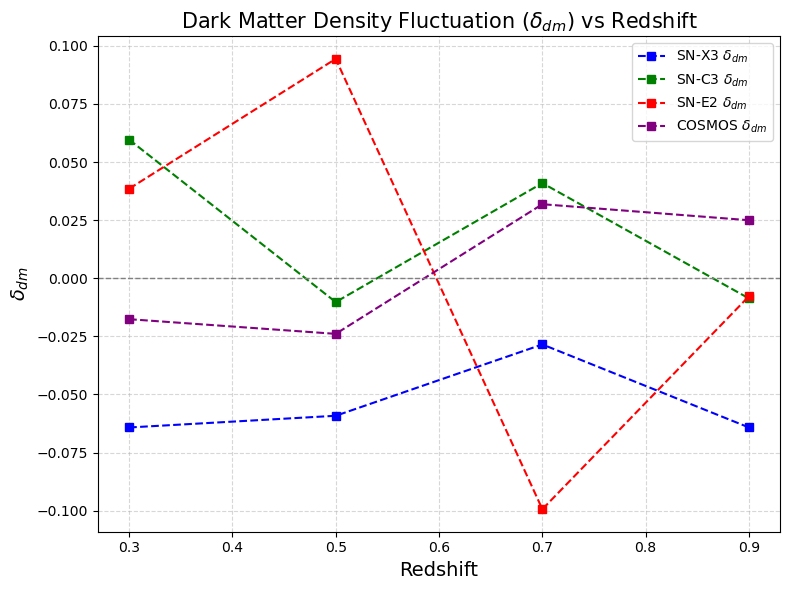

In [95]:
plt.figure(figsize=(8, 6))

# Filter to keep only redshifts >= 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]

z_centers_filtered = [z_centers[i] for i in indices]
field_delta_dm_filtered = {field: [field_delta_dm[field][i] for i in indices] for field in field_names}

for i, field in enumerate(field_names):
    plt.plot(z_centers_filtered,
             field_delta_dm_filtered[field],
             label=f'{field} $\delta_{{dm}}$',
             color=colors[i],
             marker='s',
             linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\delta_{dm}$", fontsize=14)
plt.title("Dark Matter Density Fluctuation ($\delta_{dm}$) vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("delta_dm_vs_z.png")
plt.show()


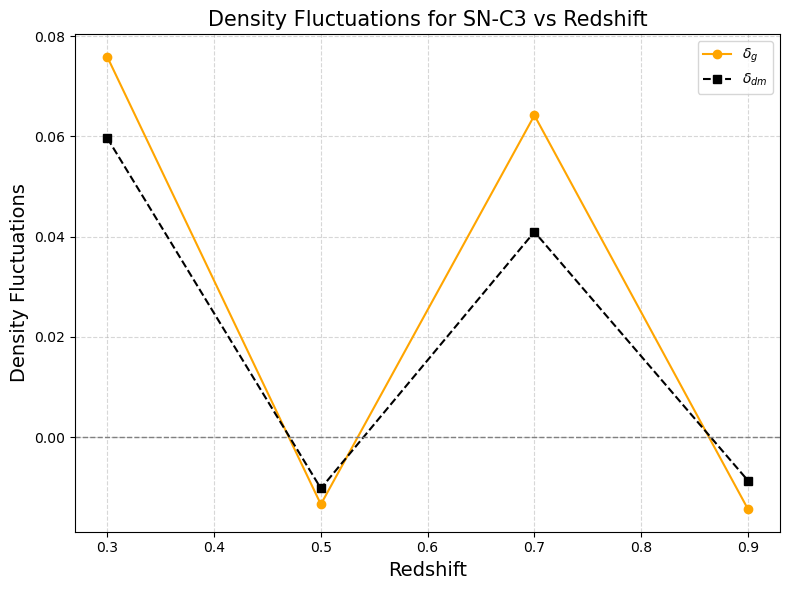

In [96]:
field = "SN-C3"

plt.figure(figsize=(8, 6))

# Filter indices for redshift >= 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]

z_centers_filtered = [z_centers[i] for i in indices]
field_delta_g_filtered = [field_delta_g[field][i] for i in indices]
field_delta_dm_filtered = [field_delta_dm[field][i] for i in indices]

# Plot delta_g
plt.plot(z_centers_filtered,
         field_delta_g_filtered,
         label=r'$\delta_g$',
         color='orange',
         marker='o',
         linestyle='-')

# Plot delta_dm
plt.plot(z_centers_filtered,
         field_delta_dm_filtered,
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Density Fluctuations", fontsize=14)
plt.title(f"Density Fluctuations for {field} vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_g_and_dm_vs_z_{field}.png")
plt.show()


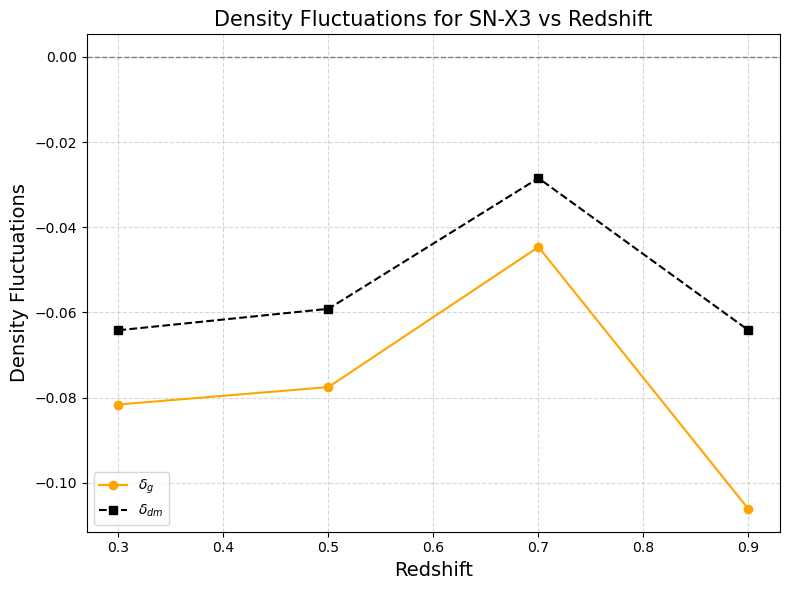

In [97]:
field = "SN-X3"

plt.figure(figsize=(8, 6))

# Filter indices for redshift >= 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]

z_centers_filtered = [z_centers[i] for i in indices]
field_delta_g_filtered = [field_delta_g[field][i] for i in indices]
field_delta_dm_filtered = [field_delta_dm[field][i] for i in indices]

# Plot delta_g
plt.plot(z_centers_filtered,
         field_delta_g_filtered,
         label=r'$\delta_g$',
         color='orange',
         marker='o',
         linestyle='-')

# Plot delta_dm
plt.plot(z_centers_filtered,
         field_delta_dm_filtered,
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Density Fluctuations", fontsize=14)
plt.title(f"Density Fluctuations for {field} vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_g_and_dm_vs_z_{field}.png")
plt.show()


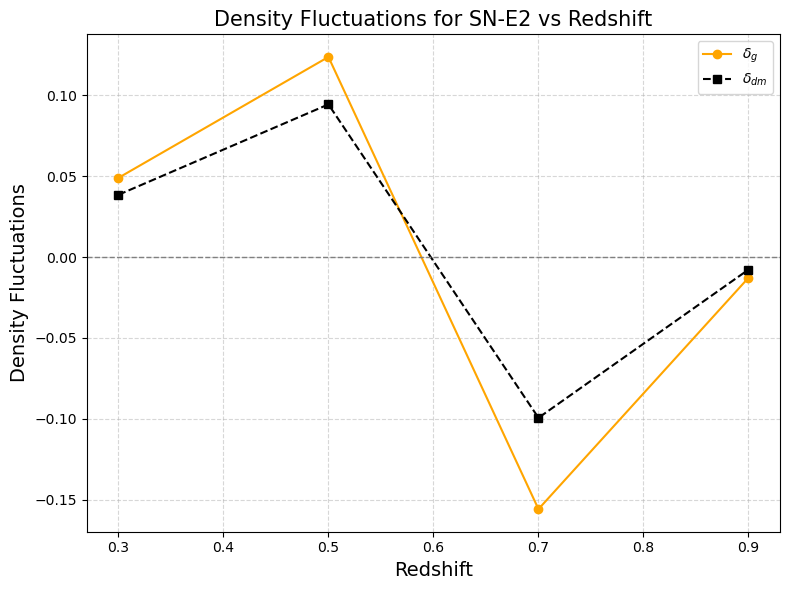

In [98]:
field = "SN-E2"

plt.figure(figsize=(8, 6))

# Filter indices for redshift >= 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]

z_centers_filtered = [z_centers[i] for i in indices]
field_delta_g_filtered = [field_delta_g[field][i] for i in indices]
field_delta_dm_filtered = [field_delta_dm[field][i] for i in indices]

# Plot delta_g
plt.plot(z_centers_filtered,
         field_delta_g_filtered,
         label=r'$\delta_g$',
         color='orange',
         marker='o',
         linestyle='-')

# Plot delta_dm
plt.plot(z_centers_filtered,
         field_delta_dm_filtered,
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Density Fluctuations", fontsize=14)
plt.title(f"Density Fluctuations for {field} vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_g_and_dm_vs_z_{field}.png")
plt.show()


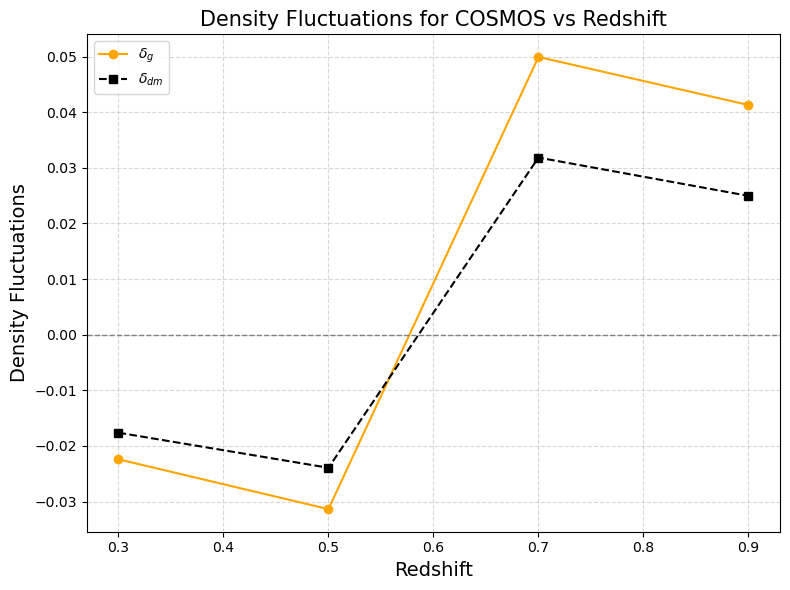

In [99]:
field = "COSMOS"

plt.figure(figsize=(8, 6))

# Filter indices for redshift >= 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]

z_centers_filtered = [z_centers[i] for i in indices]
field_delta_g_filtered = [field_delta_g[field][i] for i in indices]
field_delta_dm_filtered = [field_delta_dm[field][i] for i in indices]

# Plot delta_g
plt.plot(z_centers_filtered,
         field_delta_g_filtered,
         label=r'$\delta_g$',
         color='orange',
         marker='o',
         linestyle='-')

# Plot delta_dm
plt.plot(z_centers_filtered,
         field_delta_dm_filtered,
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Density Fluctuations", fontsize=14)
plt.title(f"Density Fluctuations for {field} vs Redshift", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_g_and_dm_vs_z_{field}.png")
plt.show()


# add 1-sigma, 2-sigma lines from the cosmic variance plot

In [119]:
"""# Load cosmic variance results
data = np.load("cosmic_variance_combined.npz")
cv_z = data["z"]
cv_sigma = data["sigma_total"]
from scipy.interpolate import interp1d

interp_sigma = interp1d(cv_z, cv_sigma, bounds_error=False, fill_value="extrapolate")
sigma_interp = interp_sigma(z_centers_filtered)"""

In [134]:
from scipy.interpolate import interp1d


cv_data = np.load(f"cosmic_variance_{field}.npz")
cv_z = cv_data["z"]
cv_sigma = cv_data["sigma"]

# Interpolate to match your filtered z_centers
interp_sigma = interp1d(cv_z, cv_sigma, bounds_error=False, fill_value="extrapolate")
sigma_interp = interp_sigma(z_centers_filtered)



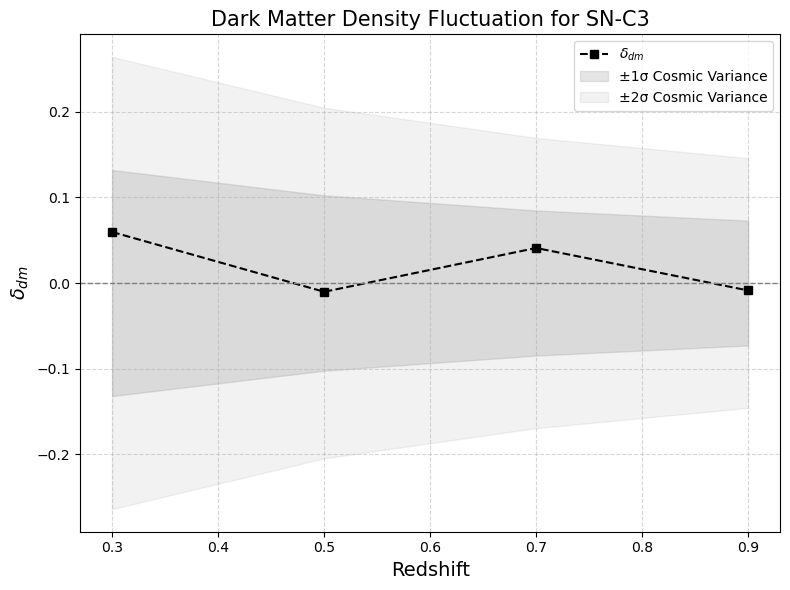

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

field = "SN-C3"

# Load field-specific cosmic variance
cv_data = np.load(f"cosmic_variance_{field}.npz")
cv_z = cv_data["z"]
cv_sigma = cv_data["sigma"]

# Filter for redshift ≥ 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]
z_centers_filtered = [z_centers[i] for i in indices]
field_delta_dm_filtered = [field_delta_dm[field][i] for i in indices]

# Interpolate sigma to match filtered z_centers
interp_sigma = interp1d(cv_z, cv_sigma, bounds_error=False, fill_value="extrapolate")
sigma_interp = interp_sigma(z_centers_filtered)

# --- Plot ---
plt.figure(figsize=(8, 6))

# Plot delta_dm
plt.plot(z_centers_filtered,
         field_delta_dm_filtered,
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

# Add 1σ and 2σ CV bands (field-specific)
plt.fill_between(z_centers_filtered,
                 sigma_interp,
                 -sigma_interp,
                 color='gray',
                 alpha=0.2,
                 label='±1σ Cosmic Variance')

plt.fill_between(z_centers_filtered,
                 2*sigma_interp,
                 -2*sigma_interp,
                 color='gray',
                 alpha=0.1,
                 label='±2σ Cosmic Variance')

# Formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\delta_{dm}$", fontsize=14)
plt.title(f"Dark Matter Density Fluctuation for {field}", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_dm_vs_z_with_cv_{field}.png")
plt.show()


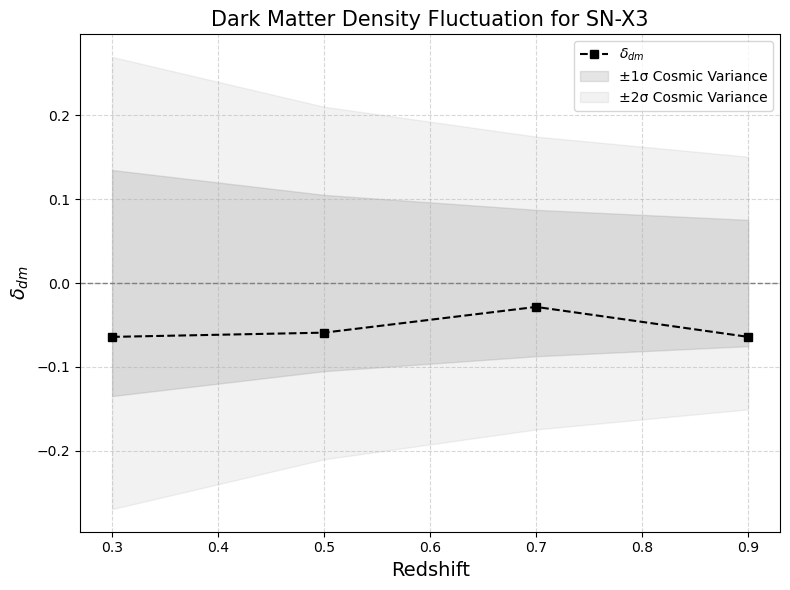

In [140]:
field = "SN-X3"

# Load field-specific cosmic variance
cv_data = np.load(f"cosmic_variance_{field}.npz")
cv_z = cv_data["z"]
cv_sigma = cv_data["sigma"]

# Filter for redshift ≥ 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]
z_centers_filtered = [z_centers[i] for i in indices]
field_delta_dm_filtered = [field_delta_dm[field][i] for i in indices]

# Interpolate sigma to match filtered z_centers
interp_sigma = interp1d(cv_z, cv_sigma, bounds_error=False, fill_value="extrapolate")
sigma_interp = interp_sigma(z_centers_filtered)

# --- Plot ---
plt.figure(figsize=(8, 6))

# Plot delta_dm
plt.plot(z_centers_filtered,
         field_delta_dm_filtered,
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

# Add 1σ and 2σ CV bands (field-specific)
plt.fill_between(z_centers_filtered,
                 sigma_interp,
                 -sigma_interp,
                 color='gray',
                 alpha=0.2,
                 label='±1σ Cosmic Variance')

plt.fill_between(z_centers_filtered,
                 2*sigma_interp,
                 -2*sigma_interp,
                 color='gray',
                 alpha=0.1,
                 label='±2σ Cosmic Variance')

# Formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\delta_{dm}$", fontsize=14)
plt.title(f"Dark Matter Density Fluctuation for {field}", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_dm_vs_z_with_cv_{field}.png")
plt.show()

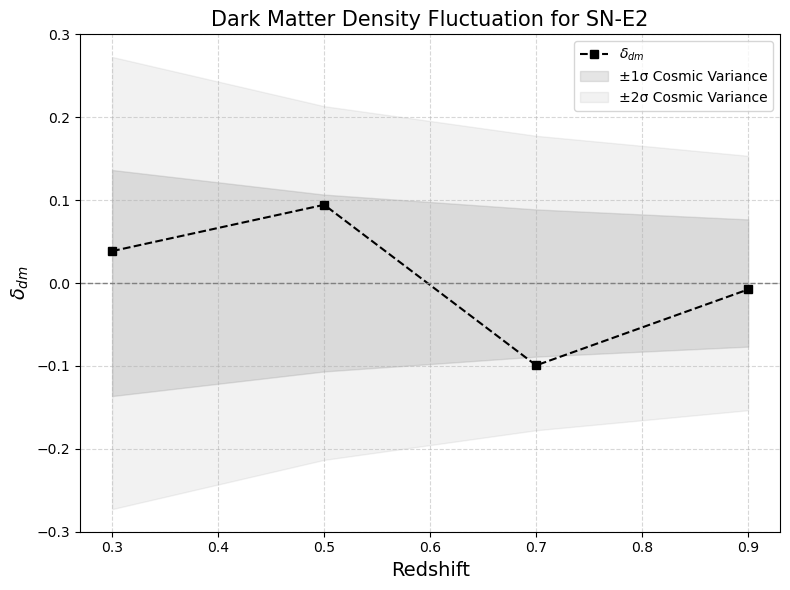

In [137]:
field = "SN-E2"

# Load field-specific cosmic variance
cv_data = np.load(f"cosmic_variance_{field}.npz")
cv_z = cv_data["z"]
cv_sigma = cv_data["sigma"]

# Filter for redshift ≥ 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]
z_centers_filtered = [z_centers[i] for i in indices]
field_delta_dm_filtered = [field_delta_dm[field][i] for i in indices]

# Interpolate sigma to match filtered z_centers
interp_sigma = interp1d(cv_z, cv_sigma, bounds_error=False, fill_value="extrapolate")
sigma_interp = interp_sigma(z_centers_filtered)

# --- Plot ---
plt.figure(figsize=(8, 6))

# Plot delta_dm
plt.plot(z_centers_filtered,
         field_delta_dm_filtered,
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

# Add 1σ and 2σ CV bands (field-specific)
plt.fill_between(z_centers_filtered,
                 sigma_interp,
                 -sigma_interp,
                 color='gray',
                 alpha=0.2,
                 label='±1σ Cosmic Variance')

plt.fill_between(z_centers_filtered,
                 2*sigma_interp,
                 -2*sigma_interp,
                 color='gray',
                 alpha=0.1,
                 label='±2σ Cosmic Variance')

# Formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\delta_{dm}$", fontsize=14)
plt.title(f"Dark Matter Density Fluctuation for {field}", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_dm_vs_z_with_cv_{field}.png")
plt.show()

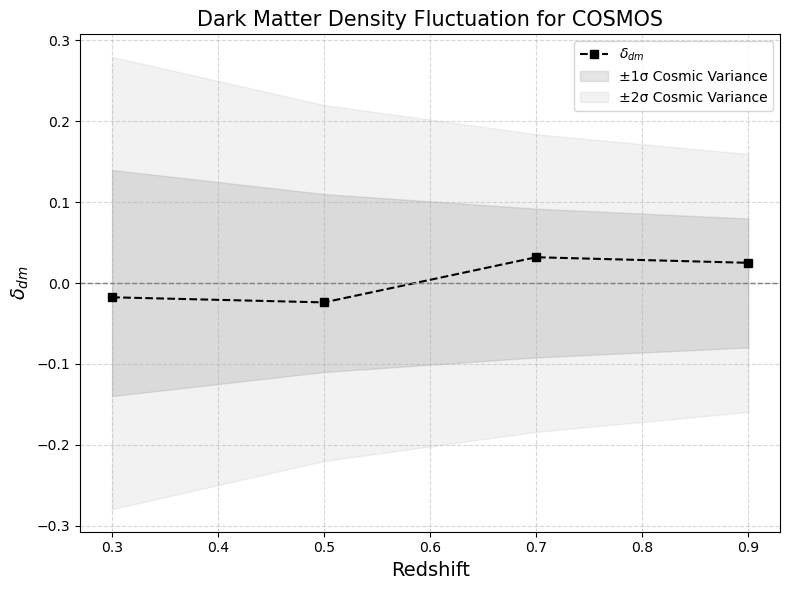

In [138]:
field = "COSMOS"

# Load field-specific cosmic variance
cv_data = np.load(f"cosmic_variance_{field}.npz")
cv_z = cv_data["z"]
cv_sigma = cv_data["sigma"]

# Filter for redshift ≥ 0.2
z_min = 0.2
indices = [i for i, z in enumerate(z_centers) if z >= z_min]
z_centers_filtered = [z_centers[i] for i in indices]
field_delta_dm_filtered = [field_delta_dm[field][i] for i in indices]

# Interpolate sigma to match filtered z_centers
interp_sigma = interp1d(cv_z, cv_sigma, bounds_error=False, fill_value="extrapolate")
sigma_interp = interp_sigma(z_centers_filtered)

# --- Plot ---
plt.figure(figsize=(8, 6))

# Plot delta_dm
plt.plot(z_centers_filtered,
         field_delta_dm_filtered,
         label=r'$\delta_{dm}$',
         color='black',
         marker='s',
         linestyle='--')

# Add 1σ and 2σ CV bands (field-specific)
plt.fill_between(z_centers_filtered,
                 sigma_interp,
                 -sigma_interp,
                 color='gray',
                 alpha=0.2,
                 label='±1σ Cosmic Variance')

plt.fill_between(z_centers_filtered,
                 2*sigma_interp,
                 -2*sigma_interp,
                 color='gray',
                 alpha=0.1,
                 label='±2σ Cosmic Variance')

# Formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\delta_{dm}$", fontsize=14)
plt.title(f"Dark Matter Density Fluctuation for {field}", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"delta_dm_vs_z_with_cv_{field}.png")
plt.show()